# Import necessary libraries

In [24]:
# Required libraries are imported.
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import timm
from tqdm import tqdm
import os
import json
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
import random
from torchvision import datasets
from torch.utils.data import DataLoader, Subset

In [25]:
import os
import json
import time
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, f1_score, roc_auc_score, roc_curve, auc,
    precision_recall_fscore_support, matthews_corrcoef, cohen_kappa_score,
    precision_recall_curve
)
from sklearn.preprocessing import label_binarize


def plotting(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history["train_loss"], label="Training Loss", marker="o", linestyle="-", color="blue")
    plt.plot(history["val_loss"], label="Validation Loss", marker="s", linestyle="-", color="red")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss")
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history["train_acc"], label="Training Accuracy", marker="o", linestyle="-", color="green")
    plt.plot(history["val_acc"], label="Validation Accuracy", marker="s", linestyle="-", color="orange")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training & Validation Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()


def evaluate_model(model, dataloader, class_names=dataset.classes, top_k=(1, 5), loader_name="Validation", model_name="Model"):
    print(f"\n========== Evaluating {model_name} on {loader_name} Set ==========\n")
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    all_preds, all_probs, all_labels = [], [], []
    top_k_correct = {k: 0 for k in top_k}
    total_samples = 0
    start_time = time.time()

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            top_k_preds = torch.topk(outputs, max(top_k), dim=1).indices.cpu().numpy()

            all_preds.extend(predicted.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            for k in top_k:
                top_k_correct[k] += np.sum(labels.cpu().numpy()[:, None] == top_k_preds[:, :k])
            total_samples += labels.size(0)

    inference_time = time.time() - start_time
    avg_inference_time = inference_time / total_samples

    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)

    cm = confusion_matrix(all_labels, all_preds)
    accuracy = np.trace(cm) / np.sum(cm) * 100
    error_rate = 100 - accuracy
    precision = np.diag(cm) / np.where(np.sum(cm, axis=0) == 0, 1, np.sum(cm, axis=0)) * 100
    recall = np.diag(cm) / np.where(np.sum(cm, axis=1) == 0, 1, np.sum(cm, axis=1)) * 100
    tn = np.sum(cm) - (np.sum(cm, axis=1) + np.sum(cm, axis=0) - np.diag(cm))
    fp = np.sum(cm, axis=0) - np.diag(cm)
    specificity = tn / np.where((tn + fp) == 0, 1, (tn + fp)) * 100

    f1_macro = f1_score(all_labels, all_preds, average="macro") * 100
    f1_weighted = f1_score(all_labels, all_preds, average="weighted") * 100
    f1_per_class = f1_score(all_labels, all_preds, average=None) * 100
    mcc = matthews_corrcoef(all_labels, all_preds) * 100
    kappa = cohen_kappa_score(all_labels, all_preds) * 100

    n_classes = len(class_names) if class_names is not None else np.max(all_labels) + 1
    if class_names is None:
        class_names = [str(i) for i in range(n_classes)]

    if n_classes > 1:
        all_labels_binarized = label_binarize(all_labels, classes=np.arange(n_classes))
        roc_auc = roc_auc_score(all_labels_binarized, all_probs, multi_class="ovr") * 100
    else:
        roc_auc = None

    top_k_accuracy = {f"Top-{k} Accuracy (%)": (top_k_correct[k] / total_samples) * 100 for k in top_k}

    unique_classes, support = np.unique(all_labels, return_counts=True)
    support_df = pd.DataFrame({
        "Class": class_names,
        "Support (Samples)": support
    })

    metrics_df = pd.DataFrame({
        "Class": class_names,
        "Precision (%)": precision,
        "Recall (%)": recall,
        "F1-Score (%)": f1_per_class,
        "Specificity (%)": specificity
    }).round(2)

    print(f"\nOverall Accuracy: {accuracy:.2f}%")
    print(f"Overall Error Rate: {error_rate:.2f}%")
    print(f"F1-Score (Macro-Averaged): {f1_macro:.2f}%")
    print(f"F1-Score (Weighted): {f1_weighted:.2f}%")
    print(f"Matthews Correlation Coefficient (MCC): {mcc:.2f}%")
    print(f"Cohen’s Kappa Score: {kappa:.2f}%")
    for k, acc in top_k_accuracy.items():
        print(f"{k}: {acc:.2f}%")
    print(f"\nAverage Inference Time per Image: {avg_inference_time:.6f} seconds")
    print("\nClass-Wise Performance Metrics:")
    print(metrics_df.to_string(index=False))
    print("\nClass-Wise Sample Distribution:")
    print(support_df.to_string(index=False))

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="g", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix: {model_name}")
    plt.tight_layout()
    plt.show()

    if roc_auc is not None:
        plt.figure(figsize=(8, 6))
        for i in range(n_classes):
            fpr, tpr, _ = roc_curve(all_labels_binarized[:, i], all_probs[:, i])
            roc_auc_val = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc_val:.2f})")
        plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve: {model_name}")
        plt.legend(loc="lower right")
        plt.tight_layout()
        plt.show()

    plt.figure(figsize=(8, 6))
    for class_idx, class_name in enumerate(class_names):
        y_true = (all_labels == class_idx).astype(int)
        y_scores = (all_preds == class_idx).astype(int)
        precision_curve, recall_curve, _ = precision_recall_curve(y_true, y_scores)
        pr_auc = auc(recall_curve, precision_curve)
        plt.plot(recall_curve, precision_curve, label=f"{class_name} (AUC = {pr_auc:.2f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve: {model_name}")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return {
        "accuracy": round(accuracy, 2),
        "error_rate": round(error_rate, 2),
        "f1_macro": round(f1_macro, 2),
        "f1_weighted": round(f1_weighted, 2),
        "roc_auc": round(roc_auc, 2) if roc_auc is not None else "N/A",
        "mcc": round(mcc, 2),
        "kappa": round(kappa, 2),
        "top_k_accuracy": top_k_accuracy,
        "avg_inference_time": avg_inference_time,
        "class_metrics": metrics_df.to_dict(orient="records"),
        "class_support": support_df.to_dict(orient="records")
    }


def save_model_artifacts(
    model,
    history,
    metrics,
    model_name="model",
    version="V1",
    base_dir="/Users/tahfimibnkhan/Desktop/ViT_Final"
):
    """
    Saves model, training metrics, and evaluation metrics in a structured format.

    Args:
        model (torch.nn.Module): Trained model to save.
        history (dict): Training history with 'train_loss', 'train_acc', 'val_loss', 'val_acc'.
        metrics (dict): Evaluation metrics dictionary.
        model_name (str): Name of the model (e.g., "deit_small", "mobilevit", etc.).
        version (str): Version identifier (e.g., "V1", "V2").
        base_dir (str): Base directory to save all artifacts.
    """
    # Save training metrics
    logs_dir = os.path.join(base_dir, "RESULTS~", "logs")
    os.makedirs(logs_dir, exist_ok=True)

    training_metrics = {
        "train_loss": history["train_loss"][-1],
        "train_acc": history["train_acc"][-1],
        "val_loss": history["val_loss"][-1],
        "val_acc": history["val_acc"][-1]
    }

    training_metrics_path = os.path.join(logs_dir, f"{model_name}_training_metrics_{version}.json")
    with open(training_metrics_path, "w") as f:
        json.dump(training_metrics, f, indent=4)
    print(f"Training metrics logged to {training_metrics_path}")

    # Save model
    model_dir = os.path.join(base_dir, "MODELS~", model_name)
    os.makedirs(model_dir, exist_ok=True)
    model.to("cpu")
    model_path = os.path.join(model_dir, f"{model_name}_{version}.pth")
    torch.save(model.state_dict(), model_path)
    print(f"Model saved to {model_path}")

    # Save evaluation metrics
    eval_dir = os.path.join(base_dir, "RESULTS~", "evaluation_logs")
    os.makedirs(eval_dir, exist_ok=True)

    eval_metrics_path = os.path.join(eval_dir, f"{model_name}_evaluation_metrics_{version}.json")
    with open(eval_metrics_path, "w") as f:
        json.dump(metrics, f, indent=4)
    print(f"Evaluation metrics saved at: {eval_metrics_path}")

    # Save class-wise metrics
    class_metrics = metrics.get("Class-Wise Metrics") or metrics.get("class_metrics")
    if class_metrics:
        class_metrics_df = pd.DataFrame(class_metrics)
        class_metrics_path = os.path.join(eval_dir, f"{model_name}_class_wise_metrics_{version}.csv")
        class_metrics_df.to_csv(class_metrics_path, index=False)
        print(f"Class-wise metrics saved at: {class_metrics_path}")
    else:
        print("No class-wise metrics found in evaluation results.")

In [26]:
# The dataset path is defined.
dataset_path = "/Users/tahfimibnkhan/Desktop/ViT/DATASET/AUGMENTED_DATASET"

# Transformations are applied to the images.
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 256x256
    transforms.ToTensor(),          # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [27]:
# The dataset is loaded using ImageFolder.
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# The number of classes in the dataset is obtained.
num_classes = len(dataset.classes)
print(f"Number of classes: {num_classes}")

Number of classes: 7


In [28]:
from torch.utils.data import random_split, DataLoader

total_size = len(dataset)

train_size = round(0.70 * total_size)
val_size = round(0.20 * total_size)
test_size = total_size - train_size - val_size

train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size],generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

print(f"Training samples: {len(train_data)}")
print(f"Validation samples: {len(val_data)}")
print(f"Test samples: {len(test_data)}")

Training samples: 3430
Validation samples: 980
Test samples: 490


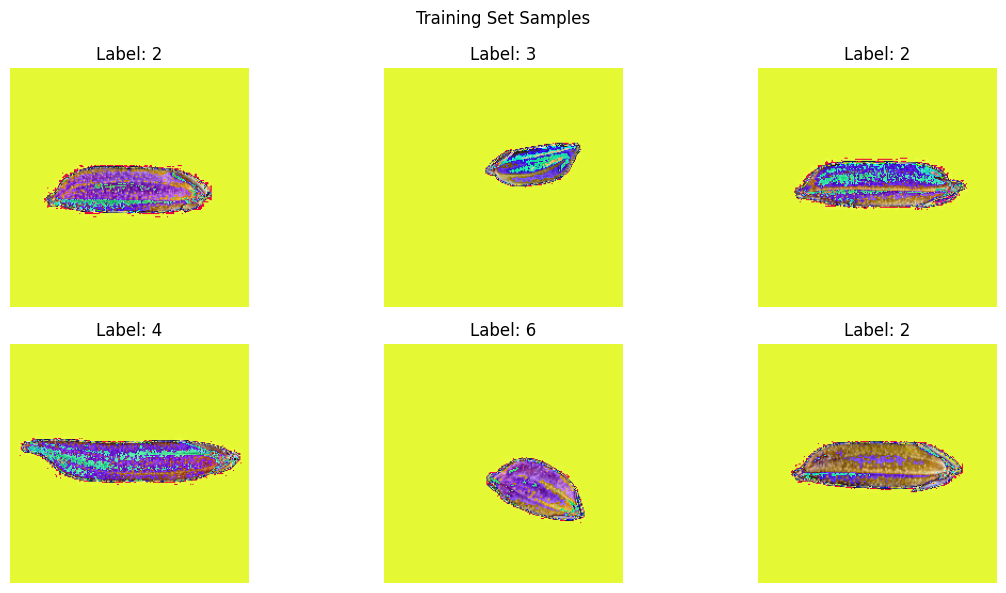

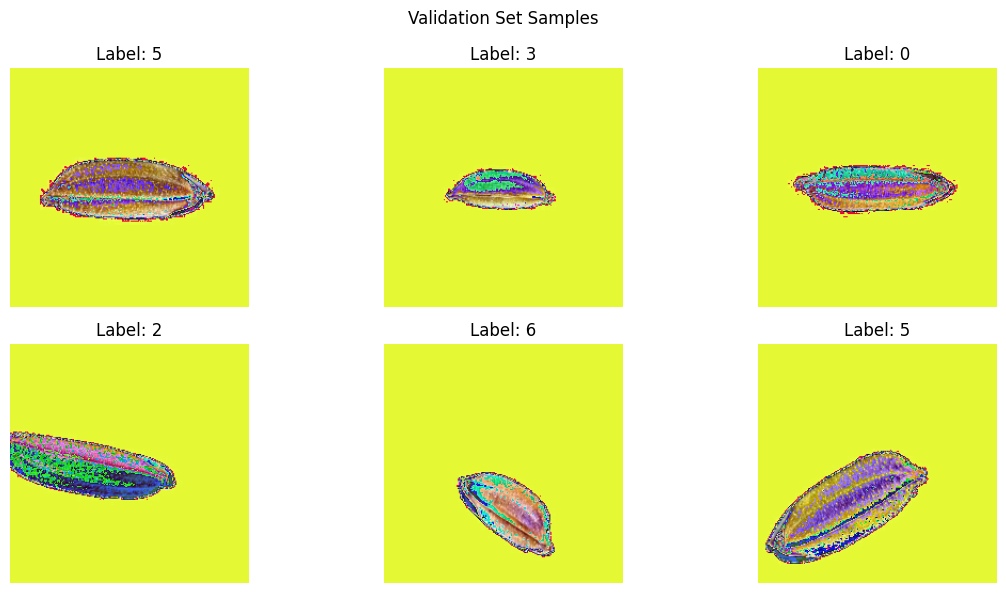

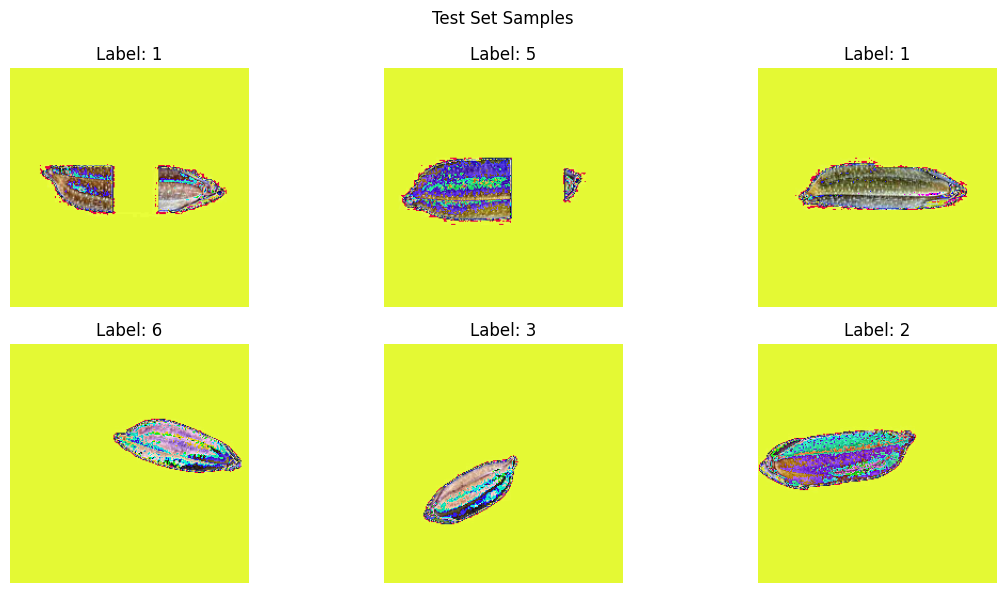

In [29]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

def show_images_from_loader(data_loader, title, num_images=6):
    data_iter = iter(data_loader)
    images, labels = next(data_iter)

    plt.figure(figsize=(12, 6))
    for i in range(num_images):
        plt.subplot(2, num_images // 2, i + 1)
        img = F.to_pil_image(images[i])  # Convert tensor to PIL Image
        plt.imshow(img)
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

show_images_from_loader(train_loader, "Training Set Samples")
show_images_from_loader(val_loader, "Validation Set Samples")
show_images_from_loader(test_loader, "Test Set Samples")

In [30]:
import timm
import torch
import torch.nn as nn

model = timm.create_model('deit_small_patch16_224', pretrained=True, num_classes=num_classes)

# Freeze all layers first
for param in model.parameters():
    param.requires_grad = False

# Unfreeze input (patch embedding) layer
for param in model.patch_embed.parameters():
    param.requires_grad = True

# Unfreeze output (classification head) layer
for param in model.head.parameters():
    param.requires_grad = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(f"Model loaded, and moved to {device}")
print("Only input (patch_embed) and output (head) layers are trainable.")

Model loaded, and moved to cpu
Only input (patch_embed) and output (head) layers are trainable.


In [31]:
import torch.optim.lr_scheduler as lr_scheduler

# Defining loss function
criterion = nn.CrossEntropyLoss()

optimizer = optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.05)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=40)

In [32]:
def train(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=20, patience=15):
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    best_val_loss = float("inf")
    early_stop_counter = 0

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct / total
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)

        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = 100. * val_correct / val_total
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        scheduler.step()

        print(f"Epoch {epoch+1}/{epochs}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        # Early Stopping Check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stop_counter = 0
            torch.save(model.state_dict(), "DeiT_best_model.pth")
            print("Model improved. Checkpoint saved.")
        else:
            early_stop_counter += 1
            print(f"No improvement. Early stopping counter: {early_stop_counter}/{patience}")
            if early_stop_counter >= patience:
                print("Early stopping triggered.")
                break

    return history
history1 = train(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=40, patience=40)

Epoch 1/40: 100%|███████████████████████████████| 54/54 [04:55<00:00,  5.47s/it]


Epoch 1/40: Train Loss: 1.2809, Train Acc: 55.16% | Val Loss: 0.8813, Val Acc: 72.14%
Model improved. Checkpoint saved.


Epoch 2/40: 100%|███████████████████████████████| 54/54 [05:46<00:00,  6.41s/it]


Epoch 2/40: Train Loss: 0.7154, Train Acc: 77.58% | Val Loss: 0.7160, Val Acc: 74.69%
Model improved. Checkpoint saved.


Epoch 3/40: 100%|███████████████████████████████| 54/54 [10:11<00:00, 11.32s/it]


Epoch 3/40: Train Loss: 0.5182, Train Acc: 82.65% | Val Loss: 0.6453, Val Acc: 75.10%
Model improved. Checkpoint saved.


Epoch 4/40: 100%|███████████████████████████████| 54/54 [10:52<00:00, 12.09s/it]


Epoch 4/40: Train Loss: 0.4356, Train Acc: 84.93% | Val Loss: 0.6468, Val Acc: 76.94%
No improvement. Early stopping counter: 1/40


Epoch 5/40: 100%|███████████████████████████████| 54/54 [11:06<00:00, 12.35s/it]


Epoch 5/40: Train Loss: 0.3358, Train Acc: 88.89% | Val Loss: 0.4100, Val Acc: 86.02%
Model improved. Checkpoint saved.


Epoch 6/40: 100%|███████████████████████████████| 54/54 [10:31<00:00, 11.70s/it]


Epoch 6/40: Train Loss: 0.2894, Train Acc: 90.52% | Val Loss: 0.5435, Val Acc: 80.61%
No improvement. Early stopping counter: 1/40


Epoch 7/40: 100%|███████████████████████████████| 54/54 [11:14<00:00, 12.48s/it]


Epoch 7/40: Train Loss: 0.2463, Train Acc: 92.86% | Val Loss: 0.4994, Val Acc: 82.96%
No improvement. Early stopping counter: 2/40


Epoch 8/40: 100%|███████████████████████████████| 54/54 [11:22<00:00, 12.64s/it]


Epoch 8/40: Train Loss: 0.2534, Train Acc: 91.57% | Val Loss: 0.4584, Val Acc: 83.27%
No improvement. Early stopping counter: 3/40


Epoch 9/40: 100%|███████████████████████████████| 54/54 [12:28<00:00, 13.86s/it]


Epoch 9/40: Train Loss: 0.1565, Train Acc: 95.54% | Val Loss: 0.3875, Val Acc: 86.84%
Model improved. Checkpoint saved.


Epoch 10/40: 100%|██████████████████████████████| 54/54 [14:06<00:00, 15.67s/it]


Epoch 10/40: Train Loss: 0.1160, Train Acc: 97.11% | Val Loss: 0.3678, Val Acc: 88.37%
Model improved. Checkpoint saved.


Epoch 11/40: 100%|██████████████████████████████| 54/54 [14:32<00:00, 16.16s/it]


Epoch 11/40: Train Loss: 0.0949, Train Acc: 97.87% | Val Loss: 0.4067, Val Acc: 87.76%
No improvement. Early stopping counter: 1/40


Epoch 12/40: 100%|██████████████████████████████| 54/54 [14:10<00:00, 15.76s/it]


Epoch 12/40: Train Loss: 0.0798, Train Acc: 98.31% | Val Loss: 0.3898, Val Acc: 87.45%
No improvement. Early stopping counter: 2/40


Epoch 13/40: 100%|██████████████████████████████| 54/54 [13:51<00:00, 15.40s/it]


Epoch 13/40: Train Loss: 0.0605, Train Acc: 99.10% | Val Loss: 0.3653, Val Acc: 88.67%
Model improved. Checkpoint saved.


Epoch 14/40: 100%|██████████████████████████████| 54/54 [12:25<00:00, 13.80s/it]


Epoch 14/40: Train Loss: 0.0430, Train Acc: 99.27% | Val Loss: 0.4309, Val Acc: 86.43%
No improvement. Early stopping counter: 1/40


Epoch 15/40: 100%|██████████████████████████████| 54/54 [13:29<00:00, 14.98s/it]


Epoch 15/40: Train Loss: 0.0397, Train Acc: 99.36% | Val Loss: 0.4858, Val Acc: 85.82%
No improvement. Early stopping counter: 2/40


Epoch 16/40: 100%|██████████████████████████████| 54/54 [12:42<00:00, 14.12s/it]


Epoch 16/40: Train Loss: 0.0342, Train Acc: 99.53% | Val Loss: 0.3117, Val Acc: 89.29%
Model improved. Checkpoint saved.


Epoch 17/40: 100%|██████████████████████████████| 54/54 [12:46<00:00, 14.19s/it]


Epoch 17/40: Train Loss: 0.0239, Train Acc: 99.77% | Val Loss: 0.3487, Val Acc: 88.98%
No improvement. Early stopping counter: 1/40


Epoch 18/40: 100%|██████████████████████████████| 54/54 [14:02<00:00, 15.61s/it]


Epoch 18/40: Train Loss: 0.0118, Train Acc: 99.97% | Val Loss: 0.3200, Val Acc: 89.80%
No improvement. Early stopping counter: 2/40


Epoch 19/40: 100%|██████████████████████████████| 54/54 [12:51<00:00, 14.29s/it]


Epoch 19/40: Train Loss: 0.0076, Train Acc: 100.00% | Val Loss: 0.3210, Val Acc: 89.59%
No improvement. Early stopping counter: 3/40


Epoch 20/40: 100%|██████████████████████████████| 54/54 [11:10<00:00, 12.42s/it]


Epoch 20/40: Train Loss: 0.0062, Train Acc: 100.00% | Val Loss: 0.3163, Val Acc: 90.00%
No improvement. Early stopping counter: 4/40


Epoch 21/40: 100%|██████████████████████████████| 54/54 [10:51<00:00, 12.06s/it]


Epoch 21/40: Train Loss: 0.0056, Train Acc: 100.00% | Val Loss: 0.3209, Val Acc: 89.80%
No improvement. Early stopping counter: 5/40


Epoch 22/40: 100%|██████████████████████████████| 54/54 [10:54<00:00, 12.12s/it]


Epoch 22/40: Train Loss: 0.0052, Train Acc: 100.00% | Val Loss: 0.3219, Val Acc: 90.00%
No improvement. Early stopping counter: 6/40


Epoch 23/40: 100%|██████████████████████████████| 54/54 [10:22<00:00, 11.53s/it]


Epoch 23/40: Train Loss: 0.0048, Train Acc: 100.00% | Val Loss: 0.3196, Val Acc: 90.00%
No improvement. Early stopping counter: 7/40


Epoch 24/40: 100%|██████████████████████████████| 54/54 [09:57<00:00, 11.07s/it]


Epoch 24/40: Train Loss: 0.0045, Train Acc: 100.00% | Val Loss: 0.3233, Val Acc: 89.80%
No improvement. Early stopping counter: 8/40


Epoch 25/40: 100%|██████████████████████████████| 54/54 [11:30<00:00, 12.80s/it]


Epoch 25/40: Train Loss: 0.0042, Train Acc: 100.00% | Val Loss: 0.3225, Val Acc: 90.00%
No improvement. Early stopping counter: 9/40


Epoch 26/40: 100%|██████████████████████████████| 54/54 [09:45<00:00, 10.84s/it]


Epoch 26/40: Train Loss: 0.0040, Train Acc: 100.00% | Val Loss: 0.3232, Val Acc: 89.90%
No improvement. Early stopping counter: 10/40


Epoch 27/40: 100%|██████████████████████████████| 54/54 [08:36<00:00,  9.57s/it]


Epoch 27/40: Train Loss: 0.0038, Train Acc: 100.00% | Val Loss: 0.3231, Val Acc: 90.10%
No improvement. Early stopping counter: 11/40


Epoch 28/40: 100%|██████████████████████████████| 54/54 [09:00<00:00, 10.01s/it]


Epoch 28/40: Train Loss: 0.0037, Train Acc: 100.00% | Val Loss: 0.3226, Val Acc: 89.90%
No improvement. Early stopping counter: 12/40


Epoch 29/40: 100%|██████████████████████████████| 54/54 [09:39<00:00, 10.73s/it]


Epoch 29/40: Train Loss: 0.0036, Train Acc: 100.00% | Val Loss: 0.3247, Val Acc: 89.90%
No improvement. Early stopping counter: 13/40


Epoch 30/40: 100%|██████████████████████████████| 54/54 [09:27<00:00, 10.51s/it]


Epoch 30/40: Train Loss: 0.0035, Train Acc: 100.00% | Val Loss: 0.3250, Val Acc: 90.10%
No improvement. Early stopping counter: 14/40


Epoch 31/40: 100%|██████████████████████████████| 54/54 [09:37<00:00, 10.69s/it]


Epoch 31/40: Train Loss: 0.0034, Train Acc: 100.00% | Val Loss: 0.3254, Val Acc: 89.90%
No improvement. Early stopping counter: 15/40


Epoch 32/40: 100%|██████████████████████████████| 54/54 [09:25<00:00, 10.47s/it]


Epoch 32/40: Train Loss: 0.0033, Train Acc: 100.00% | Val Loss: 0.3269, Val Acc: 90.10%
No improvement. Early stopping counter: 16/40


Epoch 33/40: 100%|██████████████████████████████| 54/54 [09:07<00:00, 10.15s/it]


Epoch 33/40: Train Loss: 0.0033, Train Acc: 100.00% | Val Loss: 0.3263, Val Acc: 90.10%
No improvement. Early stopping counter: 17/40


Epoch 34/40: 100%|██████████████████████████████| 54/54 [09:12<00:00, 10.23s/it]


Epoch 34/40: Train Loss: 0.0032, Train Acc: 100.00% | Val Loss: 0.3265, Val Acc: 90.10%
No improvement. Early stopping counter: 18/40


Epoch 35/40: 100%|██████████████████████████████| 54/54 [09:32<00:00, 10.60s/it]


Epoch 35/40: Train Loss: 0.0032, Train Acc: 100.00% | Val Loss: 0.3263, Val Acc: 90.00%
No improvement. Early stopping counter: 19/40


Epoch 36/40: 100%|██████████████████████████████| 54/54 [09:25<00:00, 10.48s/it]


Epoch 36/40: Train Loss: 0.0032, Train Acc: 100.00% | Val Loss: 0.3262, Val Acc: 90.00%
No improvement. Early stopping counter: 20/40


Epoch 37/40: 100%|██████████████████████████████| 54/54 [09:05<00:00, 10.11s/it]


Epoch 37/40: Train Loss: 0.0031, Train Acc: 100.00% | Val Loss: 0.3266, Val Acc: 90.10%
No improvement. Early stopping counter: 21/40


Epoch 38/40: 100%|██████████████████████████████| 54/54 [10:50<00:00, 12.04s/it]


Epoch 38/40: Train Loss: 0.0031, Train Acc: 100.00% | Val Loss: 0.3264, Val Acc: 90.00%
No improvement. Early stopping counter: 22/40


Epoch 39/40: 100%|██████████████████████████████| 54/54 [11:34<00:00, 12.86s/it]


Epoch 39/40: Train Loss: 0.0031, Train Acc: 100.00% | Val Loss: 0.3265, Val Acc: 90.00%
No improvement. Early stopping counter: 23/40


Epoch 40/40: 100%|██████████████████████████████| 54/54 [10:41<00:00, 11.88s/it]


Epoch 40/40: Train Loss: 0.0031, Train Acc: 100.00% | Val Loss: 0.3265, Val Acc: 90.00%
No improvement. Early stopping counter: 24/40


# Plotting Training & Validation Loss and Accuracy

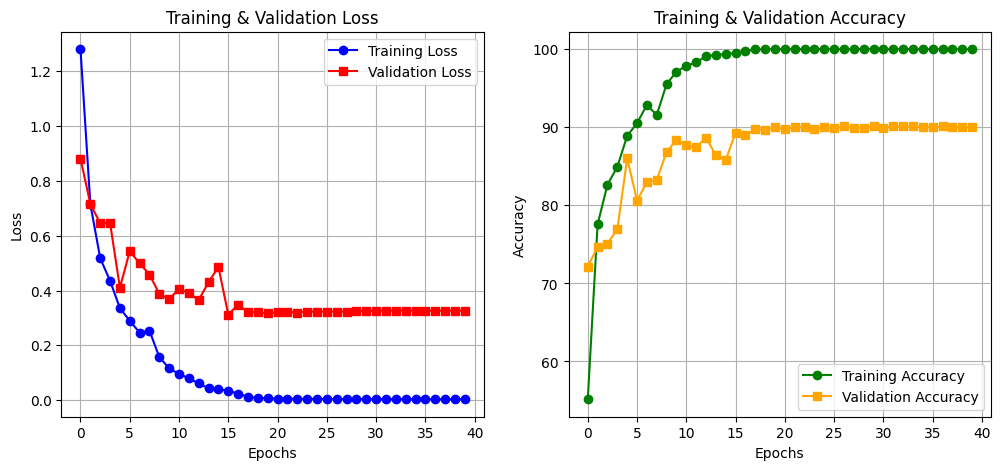

In [33]:
plotting(history1)

# Computeing Performance Metrics

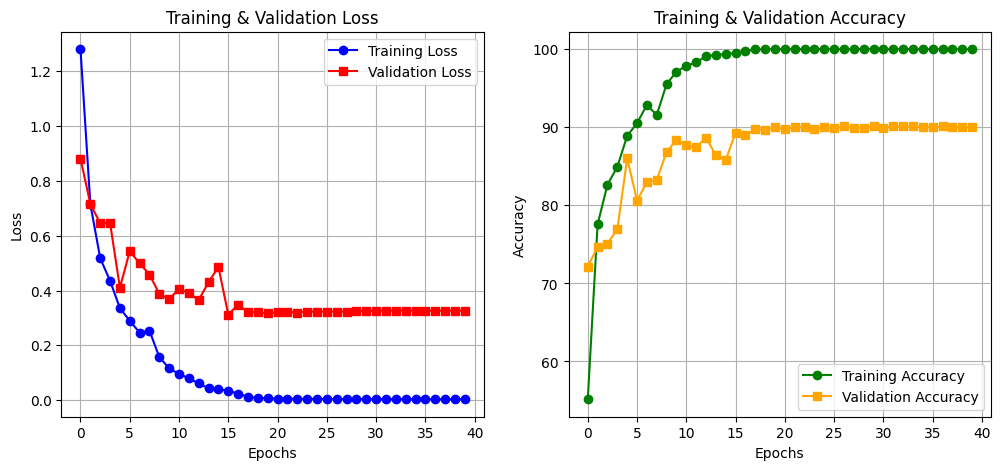


========== Evaluating DeiT-Small V1 on Validation Set ==========


Overall Accuracy: 90.00%
Overall Error Rate: 10.00%
F1-Score (Macro-Averaged): 89.94%
F1-Score (Weighted): 89.94%
Matthews Correlation Coefficient (MCC): 88.33%
Cohen’s Kappa Score: 88.32%
Top-1 Accuracy (%): 90.00%
Top-5 Accuracy (%): 100.00%

Average Inference Time per Image: 0.077382 seconds

Class-Wise Performance Metrics:
   Class  Precision (%)  Recall (%)  F1-Score (%)  Specificity (%)
BRRI_108          86.03       81.25         83.57            97.73
 BRRI_28          89.31       87.97         88.64            98.35
 BRRI_29          88.55       84.67         86.57            98.22
 BRRI_34          91.73       92.42         92.08            98.70
 BRRI_50          90.71       95.49         93.04            98.47
 BRRI_74          90.96       93.21         92.07            98.17
    BR_5          92.31       94.96         93.62            98.69

Class-Wise Sample Distribution:
   Class  Support (Samples)
BRRI_1

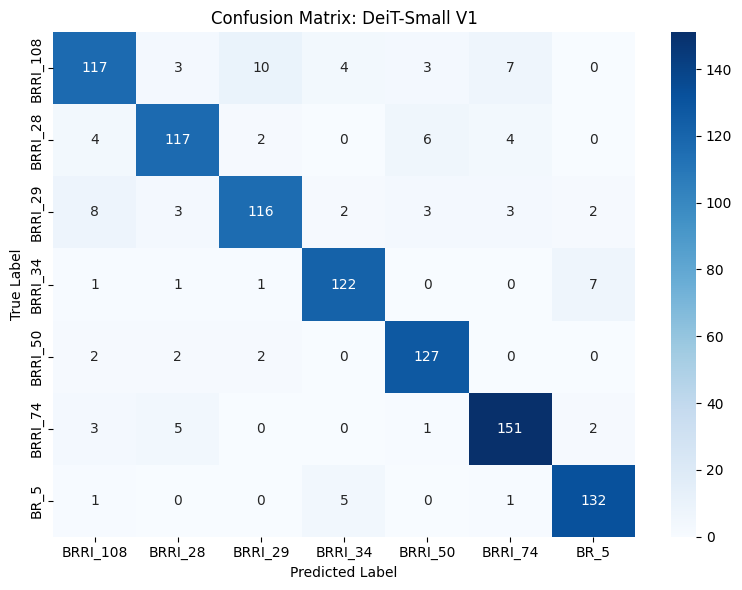

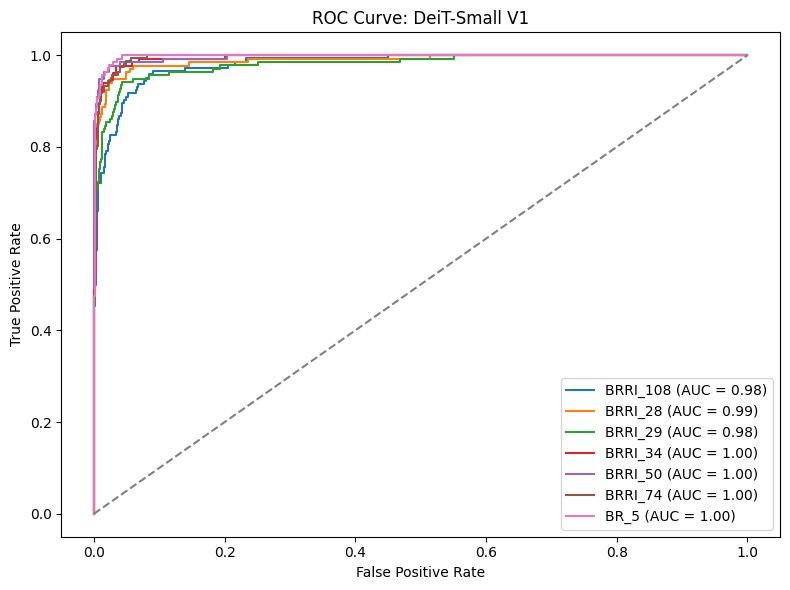

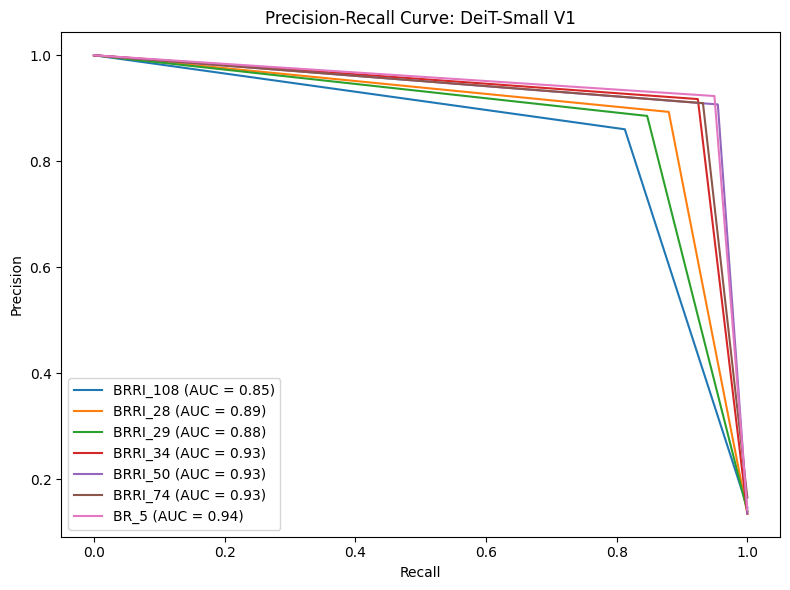


========== Evaluating DeiT-Small V1 on Tesing Set ==========


Overall Accuracy: 90.82%
Overall Error Rate: 9.18%
F1-Score (Macro-Averaged): 90.89%
F1-Score (Weighted): 90.72%
Matthews Correlation Coefficient (MCC): 89.32%
Cohen’s Kappa Score: 89.27%
Top-1 Accuracy (%): 90.82%
Top-5 Accuracy (%): 99.80%

Average Inference Time per Image: 0.077583 seconds

Class-Wise Performance Metrics:
   Class  Precision (%)  Recall (%)  F1-Score (%)  Specificity (%)
BRRI_108          82.43       82.43         82.43            96.88
 BRRI_28          95.45       96.92         96.18            99.29
 BRRI_29          90.77       80.82         85.51            98.56
 BRRI_34          95.16       85.51         90.08            99.29
 BRRI_50          90.79       97.18         93.88            98.33
 BRRI_74          93.55       95.08         94.31            99.07
    BR_5          89.41       98.70         93.83            97.82

Class-Wise Sample Distribution:
   Class  Support (Samples)
BRRI_108    

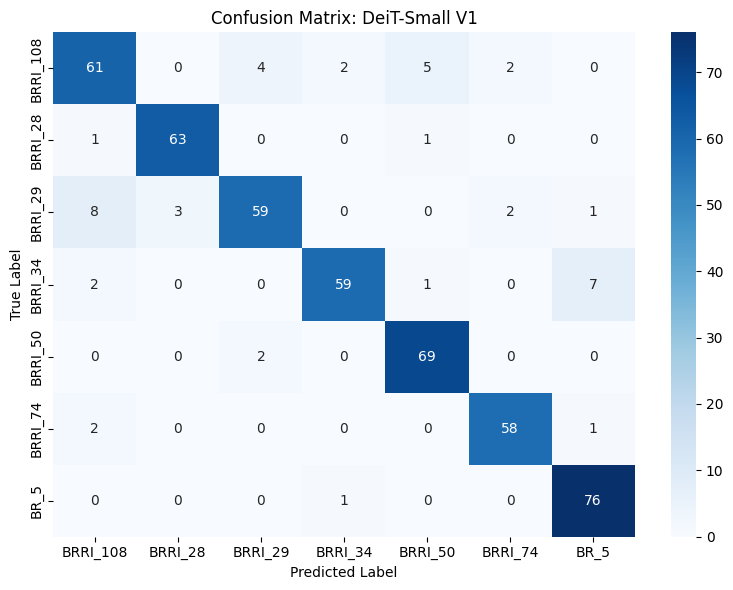

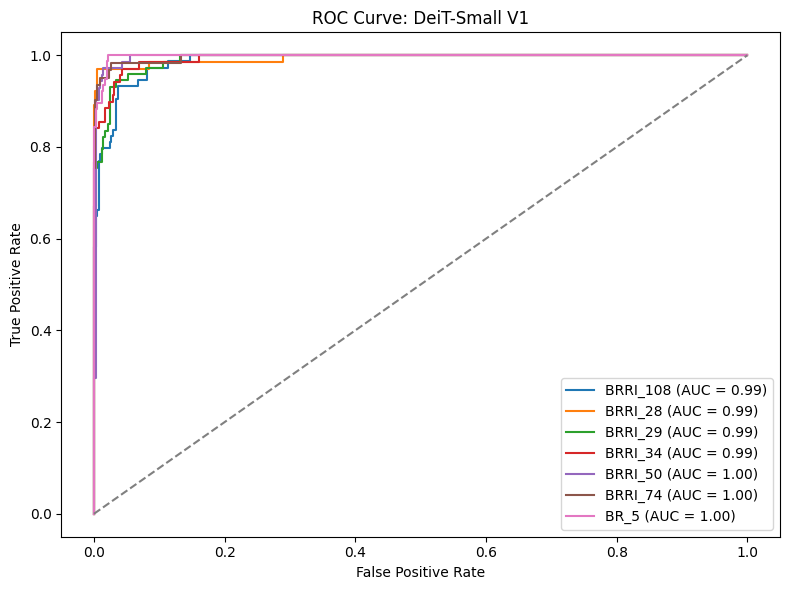

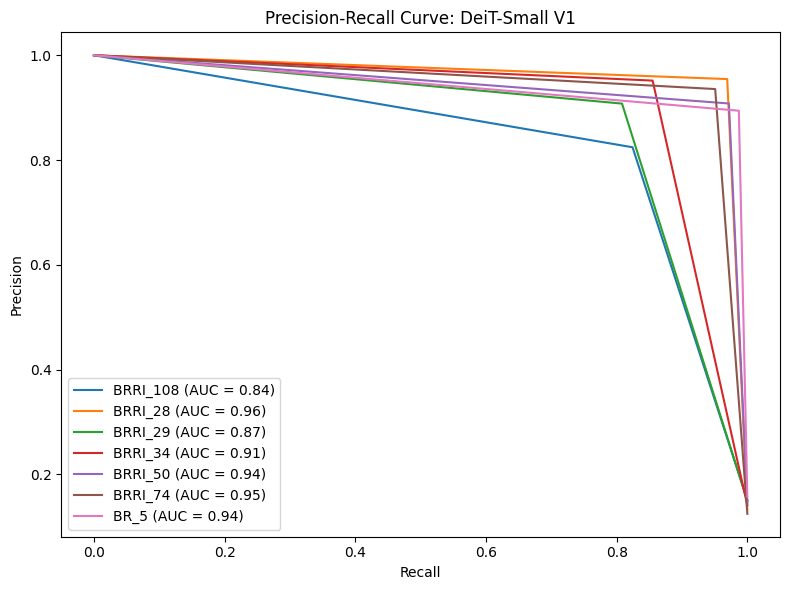

In [34]:
plotting(history1)
metrics1 = evaluate_model(model, val_loader, class_names=dataset.classes, loader_name="Validation", model_name="DeiT-Small V1")
metrics1 = evaluate_model(model, test_loader, class_names=dataset.classes, loader_name="Tesing", model_name="DeiT-Small V1")

In [35]:
save_model_artifacts(model=model,history=history1,metrics=metrics1,model_name="DeiT_small_Final",version="1")

Training metrics logged to /Users/tahfimibnkhan/Desktop/ViT_Final/RESULTS~/logs/DeiT_small_Final_training_metrics_1.json
Model saved to /Users/tahfimibnkhan/Desktop/ViT_Final/MODELS~/DeiT_small_Final/DeiT_small_Final_1.pth
Evaluation metrics saved at: /Users/tahfimibnkhan/Desktop/ViT_Final/RESULTS~/evaluation_logs/DeiT_small_Final_evaluation_metrics_1.json
Class-wise metrics saved at: /Users/tahfimibnkhan/Desktop/ViT_Final/RESULTS~/evaluation_logs/DeiT_small_Final_class_wise_metrics_1.csv


# Frezzing half ot the layers

In [36]:
import torch
import timm
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR

# Load model
model2 = timm.create_model("deit_small_patch16_224", pretrained=True, num_classes=num_classes)

for param in model2.parameters():
    param.requires_grad = False

# Unfreeze input (patch embedding) and output (head)
for param in model2.patch_embed.parameters():
    param.requires_grad = True
for param in model2.head.parameters():
    param.requires_grad = True

# Unfreeze last 3 and first 3 blocks, freeze middle 6
for i, block in enumerate(model2.blocks):
    if i < 3 or i >= 9:  # Keep first 3 and last 3 unfrozen
        for param in block.parameters():
            param.requires_grad = True

# Load saved weights
checkpoint_path = "/Users/tahfimibnkhan/Desktop/ViT_Final/MODELS~/DeiT_small_Final/DeiT_small_Final_1.pth"
model2.load_state_dict(torch.load(checkpoint_path))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2.to(device)

print(f"Model reloaded from {checkpoint_path} and moved to {device}")

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model2.parameters(), lr=5e-4, weight_decay=0.05)
scheduler = CosineAnnealingLR(optimizer, T_max=20)

Model reloaded from /Users/tahfimibnkhan/Desktop/ViT_Final/MODELS~/DeiT_small_Final/DeiT_small_Final_1.pth and moved to cpu


In [38]:
history2 = train(
    model=model2,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    epochs=20,
    patience=20
)

Epoch 1/20: 100%|███████████████████████████████| 54/54 [13:40<00:00, 15.19s/it]


Epoch 1/20: Train Loss: 1.8847, Train Acc: 28.89% | Val Loss: 1.4263, Val Acc: 44.08%
Model improved. Checkpoint saved.


Epoch 2/20: 100%|███████████████████████████████| 54/54 [11:51<00:00, 13.18s/it]


Epoch 2/20: Train Loss: 1.3095, Train Acc: 48.54% | Val Loss: 1.1265, Val Acc: 56.43%
Model improved. Checkpoint saved.


Epoch 3/20: 100%|███████████████████████████████| 54/54 [11:17<00:00, 12.55s/it]


Epoch 3/20: Train Loss: 0.9214, Train Acc: 65.36% | Val Loss: 0.7445, Val Acc: 72.24%
Model improved. Checkpoint saved.


Epoch 4/20: 100%|███████████████████████████████| 54/54 [11:52<00:00, 13.19s/it]


Epoch 4/20: Train Loss: 0.6587, Train Acc: 74.64% | Val Loss: 0.6627, Val Acc: 76.73%
Model improved. Checkpoint saved.


Epoch 5/20: 100%|███████████████████████████████| 54/54 [10:49<00:00, 12.02s/it]


Epoch 5/20: Train Loss: 0.4949, Train Acc: 81.60% | Val Loss: 0.5866, Val Acc: 80.10%
Model improved. Checkpoint saved.


Epoch 6/20: 100%|███████████████████████████████| 54/54 [11:42<00:00, 13.01s/it]


Epoch 6/20: Train Loss: 0.4082, Train Acc: 83.32% | Val Loss: 0.6270, Val Acc: 79.18%
No improvement. Early stopping counter: 1/20


Epoch 7/20: 100%|███████████████████████████████| 54/54 [11:01<00:00, 12.25s/it]


Epoch 7/20: Train Loss: 0.2524, Train Acc: 90.55% | Val Loss: 0.4889, Val Acc: 83.98%
Model improved. Checkpoint saved.


Epoch 8/20: 100%|███████████████████████████████| 54/54 [11:00<00:00, 12.23s/it]


Epoch 8/20: Train Loss: 0.1546, Train Acc: 94.58% | Val Loss: 0.5353, Val Acc: 83.37%
No improvement. Early stopping counter: 1/20


Epoch 9/20: 100%|███████████████████████████████| 54/54 [11:34<00:00, 12.86s/it]


Epoch 9/20: Train Loss: 0.0846, Train Acc: 96.76% | Val Loss: 0.6131, Val Acc: 82.76%
No improvement. Early stopping counter: 2/20


Epoch 10/20: 100%|██████████████████████████████| 54/54 [12:25<00:00, 13.80s/it]


Epoch 10/20: Train Loss: 0.0472, Train Acc: 98.40% | Val Loss: 0.5273, Val Acc: 85.31%
No improvement. Early stopping counter: 3/20


Epoch 11/20: 100%|██████████████████████████████| 54/54 [12:57<00:00, 14.39s/it]


Epoch 11/20: Train Loss: 0.0398, Train Acc: 98.78% | Val Loss: 0.4712, Val Acc: 86.73%
Model improved. Checkpoint saved.


Epoch 12/20: 100%|██████████████████████████████| 54/54 [11:34<00:00, 12.86s/it]


Epoch 12/20: Train Loss: 0.0209, Train Acc: 99.39% | Val Loss: 0.4723, Val Acc: 87.45%
No improvement. Early stopping counter: 1/20


Epoch 13/20: 100%|██████████████████████████████| 54/54 [11:32<00:00, 12.83s/it]


Epoch 13/20: Train Loss: 0.0025, Train Acc: 100.00% | Val Loss: 0.4670, Val Acc: 87.65%
Model improved. Checkpoint saved.


Epoch 14/20: 100%|██████████████████████████████| 54/54 [12:44<00:00, 14.17s/it]


Epoch 14/20: Train Loss: 0.0010, Train Acc: 100.00% | Val Loss: 0.4634, Val Acc: 88.27%
Model improved. Checkpoint saved.


Epoch 15/20: 100%|██████████████████████████████| 54/54 [13:02<00:00, 14.49s/it]


Epoch 15/20: Train Loss: 0.0007, Train Acc: 100.00% | Val Loss: 0.4644, Val Acc: 88.47%
No improvement. Early stopping counter: 1/20


Epoch 16/20: 100%|██████████████████████████████| 54/54 [11:59<00:00, 13.32s/it]


Epoch 16/20: Train Loss: 0.0006, Train Acc: 100.00% | Val Loss: 0.4656, Val Acc: 88.47%
No improvement. Early stopping counter: 2/20


Epoch 17/20: 100%|██████████████████████████████| 54/54 [10:46<00:00, 11.98s/it]


Epoch 17/20: Train Loss: 0.0006, Train Acc: 100.00% | Val Loss: 0.4663, Val Acc: 88.57%
No improvement. Early stopping counter: 3/20


Epoch 18/20: 100%|██████████████████████████████| 54/54 [10:53<00:00, 12.11s/it]


Epoch 18/20: Train Loss: 0.0006, Train Acc: 100.00% | Val Loss: 0.4667, Val Acc: 88.47%
No improvement. Early stopping counter: 4/20


Epoch 19/20: 100%|██████████████████████████████| 54/54 [10:48<00:00, 12.01s/it]


Epoch 19/20: Train Loss: 0.0005, Train Acc: 100.00% | Val Loss: 0.4669, Val Acc: 88.47%
No improvement. Early stopping counter: 5/20


Epoch 20/20: 100%|██████████████████████████████| 54/54 [10:34<00:00, 11.75s/it]


Epoch 20/20: Train Loss: 0.0005, Train Acc: 100.00% | Val Loss: 0.4669, Val Acc: 88.47%
No improvement. Early stopping counter: 6/20


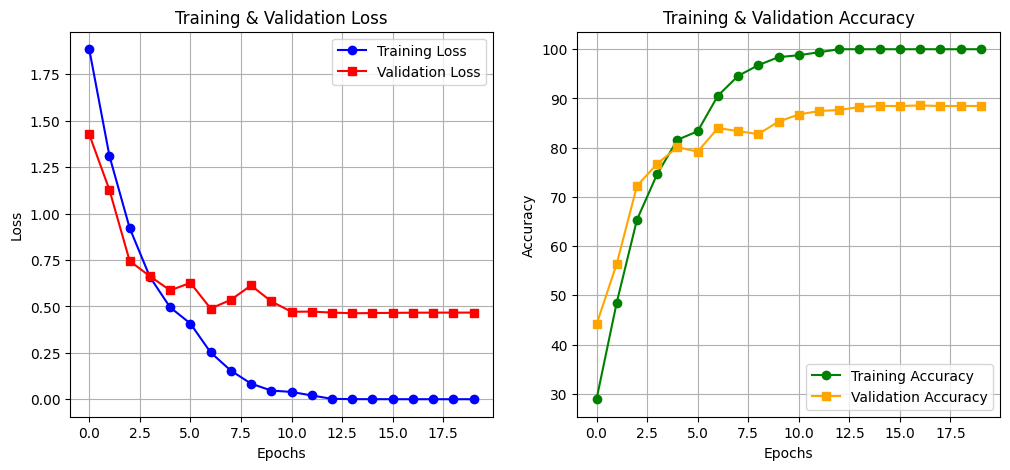


========== Evaluating DeiT-Small V2 on Validation Set ==========


Overall Accuracy: 88.47%
Overall Error Rate: 11.53%
F1-Score (Macro-Averaged): 88.43%
F1-Score (Weighted): 88.45%
Matthews Correlation Coefficient (MCC): 86.55%
Cohen’s Kappa Score: 86.54%
Top-1 Accuracy (%): 88.47%
Top-5 Accuracy (%): 99.90%

Average Inference Time per Image: 0.057653 seconds

Class-Wise Performance Metrics:
   Class  Precision (%)  Recall (%)  F1-Score (%)  Specificity (%)
BRRI_108          83.94       79.86         81.85            97.37
 BRRI_28          87.32       93.23         90.18            97.87
 BRRI_29          83.94       83.94         83.94            97.39
 BRRI_34          86.96       90.91         88.89            97.88
 BRRI_50          91.47       88.72         90.08            98.70
 BRRI_74          91.88       90.74         91.30            98.41
    BR_5          93.43       92.09         92.75            98.93

Class-Wise Sample Distribution:
   Class  Support (Samples)
BRRI_10

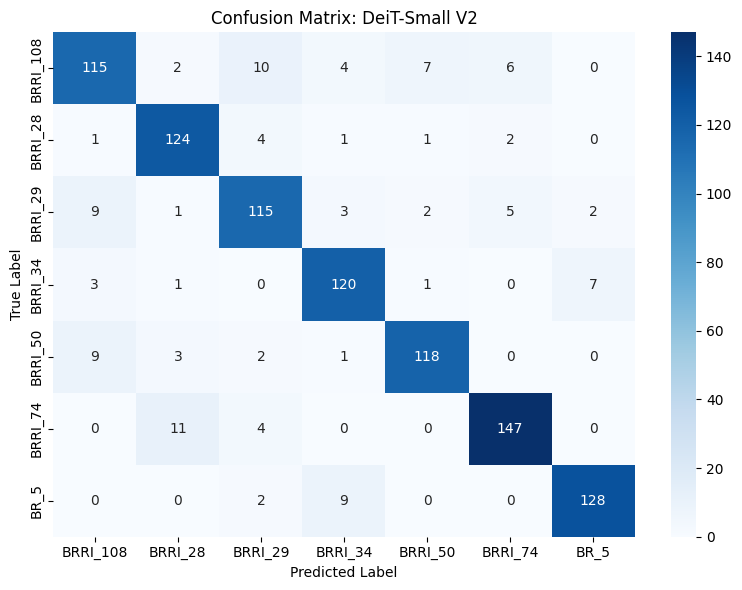

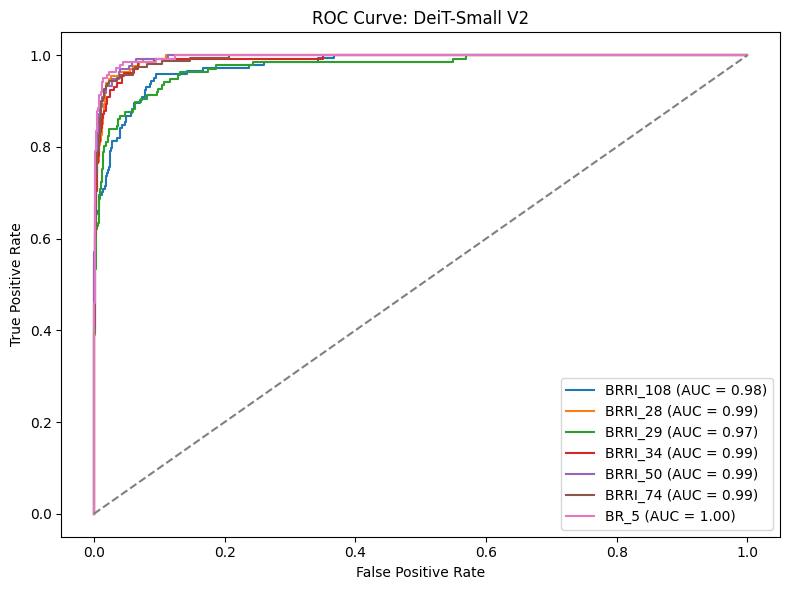

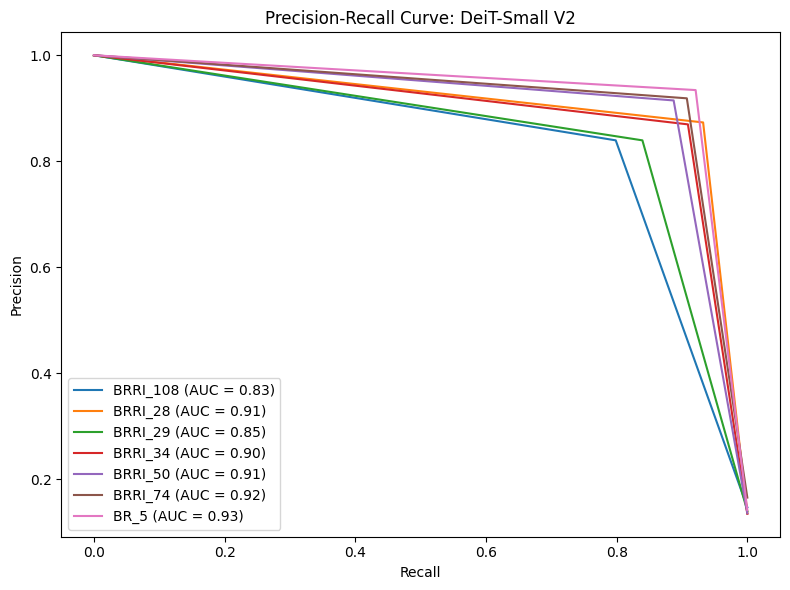


========== Evaluating DeiT-Small V2 on Tesing Set ==========


Overall Accuracy: 88.78%
Overall Error Rate: 11.22%
F1-Score (Macro-Averaged): 88.76%
F1-Score (Weighted): 88.65%
Matthews Correlation Coefficient (MCC): 86.94%
Cohen’s Kappa Score: 86.89%
Top-1 Accuracy (%): 88.78%
Top-5 Accuracy (%): 100.00%

Average Inference Time per Image: 0.057222 seconds

Class-Wise Performance Metrics:
   Class  Precision (%)  Recall (%)  F1-Score (%)  Specificity (%)
BRRI_108          86.36       77.03         81.43            97.84
 BRRI_28          90.00       96.92         93.33            98.35
 BRRI_29          89.71       83.56         86.52            98.32
 BRRI_34          92.06       84.06         87.88            98.81
 BRRI_50          85.71       92.96         89.19            97.37
 BRRI_74          90.32       91.80         91.06            98.60
    BR_5          88.10       96.10         91.93            97.58

Class-Wise Sample Distribution:
   Class  Support (Samples)
BRRI_108  

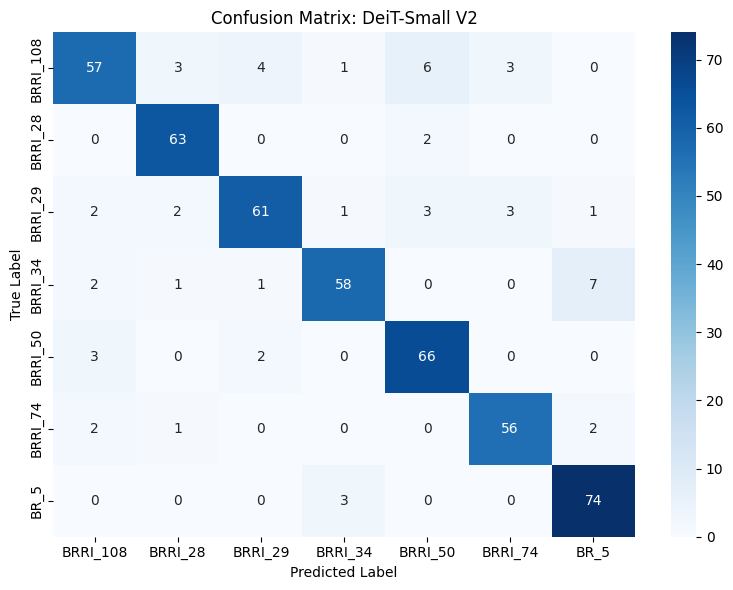

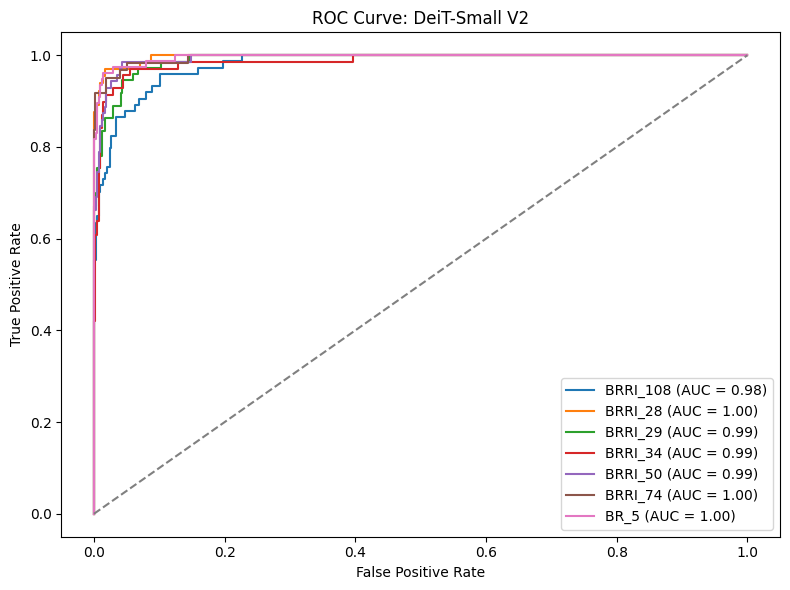

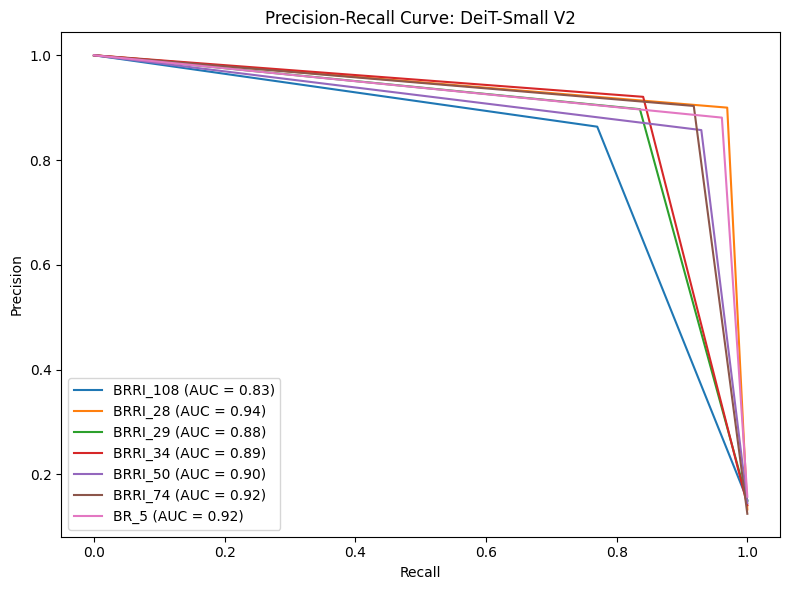

In [39]:
plotting(history2)
metrics1 = evaluate_model(model2, val_loader, class_names=dataset.classes, loader_name="Validation", model_name="DeiT-Small V2")
metrics1 = evaluate_model(model2, test_loader, class_names=dataset.classes, loader_name="Tesing", model_name="DeiT-Small V2")